In [2]:
#import library for sentiment analysis
import pandas as pd
import re
import nltk
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
from swifter import swifter
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import train_test_split
import googletrans
from googletrans import Translator
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder

c:\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
# Import file csv
df_1 = pd.read_csv('data/crawl_sentimen_siakad_2009.csv',sep=';')
df_2 = pd.read_csv('data/crawl_sentimen_siakad_2009_part2.csv',sep=';')

# Merge file csv
df = pd.concat([df_1, df_2], ignore_index=True)

df['full_text'][1744]

'@MABA_UNJ : min mau tanya, login SIAKAD ko gagal terus ya? Passwors tanggal pembayaran min? Bisa di pandu.?'

In [3]:
# Cek dimensi dataframe
df.shape

(1748, 12)

## Data Preprocessingg

In [4]:
#ambil kolom yang dibutuhkan
df = df[['created_at','full_text','username']]

#cek duplikasi data
df.duplicated().sum()

#drop duplikasi data
df.drop_duplicates(inplace=True)

#cek dimensi dataframe
df.shape

#cek missing value
df.isnull().sum()

#drop missing value
df.dropna(inplace=True)

#cek dimensi dataframe
df.shape

# Ubah tipe data kolom created_at menjadi datetime tanpa waktu
df['created_at'] = pd.to_datetime(df['created_at']).dt.date
df.tail()

C:\Users\force\AppData\Local\Temp\ipykernel_16628\4121230747.py:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['created_at'] = pd.to_datetime(df['created_at']).dt.date


,created_at,full_text,username
1743,2013-08-06,Ngemeng2 singkatan siskamaya itu apa? Kok tau ...,Rachmatrezzz
1744,2013-08-06,"@MABA_UNJ : min mau tanya, login SIAKAD ko gag...",aswardinnwokolo
1745,2013-08-06,"Hoy Dee, informasi2 ospek unj liat dimana? Trs...",rendyarmel
1746,2013-08-05,Kenalan ngajak ribut hahaha@v_nanovianti: dewi...,dewintaan
1747,2013-08-05,@dewintaan hahaha .. sabar ya cantiiiik :) bia...,vinanoviantii


In [9]:
# Case Folding
df['full_text'] = df['full_text'].str.lower()
# lebarkan kolomnya
pd.set_option('display.max_colwidth', None)
df['full_text'][1744]

'@maba_unj : min mau tanya, login siakad ko gagal terus ya? passwors tanggal pembayaran min? bisa di pandu.?'

In [13]:
#Preprocessing cleaning and Tokenizing
def remove_tweet_special(text):
    #remove tab, new line, ans back slice
    text = text.replace('\\t'," ").replace('\\n'," ").replace('\\u'," ").replace('\\',"")
    #remove non ASCII (emoticon, chinese word,etc)
    text = text.encode('ascii','replace').decode('ascii')
    #remove mention,link,hastag
    text = ' '.join(re.sub("([@#][A-Za-z0-9]+)|(\w+:\/\/\S+)"," ",text).split())
    #remove incomplete URL
    return text.replace("http://"," ").replace("https://"," ")

df['full_text'] = df['full_text'].apply(remove_tweet_special)

#remove number
def remove_number(text):
    return re.sub(r"\d+","", text)
df['full_text'] = df['full_text'].apply(remove_number)

#remove punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans("","",string.punctuation))
df['full_text']= df['full_text'].apply(remove_punctuation)

#remove whitespacing leading & trailing
def remove_whitespace_LT(text):
    return text.strip()
df['full_text']= df['full_text'].apply(remove_whitespace_LT)

#remove multiple whitespace into single white space
def remove_whitespace_multiple(text):
    return re.sub('\s+',' ',text)

df['full_text']= df['full_text'].apply(remove_whitespace_multiple)

#remove single char
def remove_singl_char(text):
    return re.sub(r"\b[a-zA-zZ]\b","",text)
df['full_text']= df['full_text'].apply(remove_singl_char)

#NLTK word tokenize
def word_tokenize_wrapper(text):
    return word_tokenize(text)
df['tweet_tokens']= df['full_text'].apply(word_tokenize_wrapper)

print('Cleaning and Tokenizing Result : \n')
print(df['tweet_tokens'].head())
print('\n\n\n')

Cleaning and Tokenizing Result : 

['hoy', 'dee', 'informasi', 'ospek', 'unj', 'liat', 'dimana', 'trs', 'siakad', 'ampe', 'sekarng', 'lemot', 'prhgua', 'beloman', 'itu', 'batesny', 'ampe', 'kapan', 'lo', 'udah']






In [15]:
# Filtering with StopWord
list_stopwords = stopwords.words('indonesian')

# manually add stopword
# append additional stopword
list_stopwords.extend(["yg", "dg", "rt", "dgn", "ny", "d", "klo", "kalo",
                        "amp", "biar", "bikin", "bilang", "gak", "ga",
                        "krn", "nya", "nih", "sih", "si", "tau", "tdk",
                        "tuh", "utk", "ya", "jd", "jgn", "sdh", "aja",
                        "n", "t", "nyg", "hehe", "pen", "u", "nan", "loh",
                        "rt", "&amp", "yah", "tau", "dahal", "yh"])

# convert list to dictionaty
list_stopwords = set(list_stopwords)

# remove stopword pada list token


def stopwords_removal(words):
    return [word for word in words if word not in list_stopwords]


df['tweet_tokens_WSW'] = df['tweet_tokens'].apply(stopwords_removal)

print(df['tweet_tokens_WSW'][1745])

['hoy', 'dee', 'informasi', 'ospek', 'unj', 'liat', 'dimana', 'trs', 'siakad', 'ampe', 'sekarng', 'lemot', 'prhgua', 'beloman', 'batesny', 'ampe', 'lo', 'udah']


In [19]:
#Stemming
#create stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

#stemmed
def stemmed_wrapper(term):
    return stemmer.stem(term)
term_dict = {}

for document in df['tweet_tokens_WSW']:
    for term in document:
        if term not in term_dict:
            term_dict[term] = ' '
            
print(len(term_dict))
print("------------------")

for term in term_dict:
    term_dict[term] = stemmed_wrapper(term)
    print(term,":" ,term_dict[term])
    
print(term_dict)
print("------------------")

#apply stemmed term to dataframe
def get_stemmed_term(document):
    return [term_dict[term]for term in document]

df['tweet_tokens_stemmed']= df['tweet_tokens_WSW'].swifter.apply(get_stemmed_term)
print(df['tweet_tokens_stemmed'])

3672
------------------
gatau : gatau
knp : knp
pangkalan : pangkal
data : data
pddikti : pddikti
siakad : siakad
unj : unj
muter : muter
doang : doang
buka : buka
yutup : yutup
sabi : sabi
haloo : haloo
terkait : kait
pengisian : isi
nanyanya : nanyanya
yaa : yaa
tu : tu
prodi : prodi
kah : kah
simak : simak
informasinya : informasi
mpers : mpers
muda : muda
mahasiswa : mahasiswa
cek : cek
ulang : ulang
melengkapi : lengkap
laman : laman
diisikan : isi
informasi : informasi
perbaikan : baik
halo : halo
angkatan : angkat
yukk : yukk
diperhatikan : perhati
from : from
maba : maba
to : to
all : all
kating : kating
message : message
solusi : solusi
kaya : kaya
gini : gin
gimana : gimana
login : login
wifi : wifi
laptop : laptop
link : link
gtu : gtu
mluu : mluu
pake : pake
akun : akun
hp : hp
bisaaamp : bisaaamp
kenceng : kenceng
liat : liat
email : email
password : password
dimana : mana
home : home
udah : udah
gaada : gaada
ganyimpen : ganyimpen
gawat : gawat
gue : gue
lupa : lupa
pw : 

Pandas Apply: 100%|██████████| 1748/1748 [00:00<00:00, 255930.58it/s]

0                                                                                                                [gatau, knp, pangkal, data, pddikti, siakad, unj, muter, doang, buka, yutup, sabi]
1                                                                                                                                    [unj, haloo, kait, isi, siakad, nanyanya, yaa, tu, prodi, kah]
2                                                                                         [simak, informasi, yaa, mpers, muda, mahasiswa, cek, ulang, lengkap, data, laman, siakad, unj, data, isi]
3                                               [informasi, isi, baik, data, siakad, unj, halo, mpers, informasi, mpers, angkat, yukk, perhati, yaa, informasi, kait, isi, baik, data, mpers, muda]
4       [from, maba, to, all, kating, unj, message, solusi, kaya, gin, gimana, login, wifi, unj, mahasiswa, siakad, laptop, link, login, kaya, gtu, mluu, login, pake, akun, hp, bisaaamp, kenceng]
                    

In [ ]:
# Simpan hasil preprocessing
df.to_csv('data/siakad_preprocessing.csv', index=False)

In [6]:
# Read File Preprocessing
df_siakad = pd.read_csv('data/siakad_preprocessing.csv',delimiter=',')
df_siakad['tweet_tokens_stemmed'].tail()

1709    ['ngemeng', 'singkat', 'siskamaya', 'lu', 'sia...
1710    ['unj', 'min', 'login', 'siakad', 'ko', 'gagal...
1711    ['hoy', 'dee', 'informasi', 'ospek', 'unj', 'l...
1712    ['kenal', 'ngajak', 'ribut', 'hahaha', 'nanovi...
1713    ['hahaha', 'sabar', 'cantiiiik', 'siakad', 'ng...
Name: tweet_tokens_stemmed, dtype: object

In [28]:
# hapus tanda [] pada kolom tweet_tokens_stemmed lalu replace petik 1 dengan kosong lalu split berdasarkan koma
df_preprocessing = df_siakad['tweet_tokens_stemmed'].str.strip("[]").str.replace("'","").str.split(", ")

text_wordcloud = df_preprocessing.apply(lambda x: " ".join(x))
# join textnya
text_wordcloud = " ".join(text_wordcloud)
# cek frekuensi kata
# text_wordcloud = text_wordcloud.split(" ")
# # hitung frekuensi kata
# text_wordcloud = pd.Series(text_wordcloud).value_counts()
# # ambil 100 kata teratas
# text_wordcloud = text_wordcloud[3:15]
# print(text_wordcloud)

buka         292
min          235
krs          229
mahasiswa    175
jadwal       170
udah         156
akses        154
nilai        141
login        113
bayar        109
maba         103
gimana       100
Name: count, dtype: int64


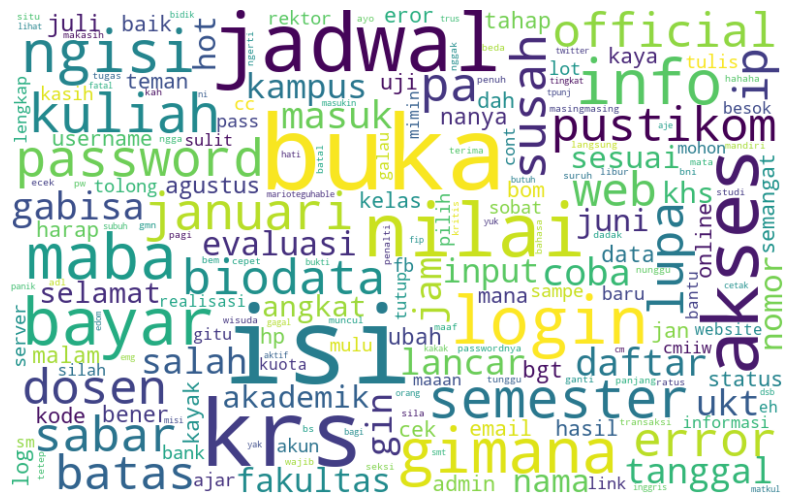

In [26]:


# Define a list of stop words
stopwords = [
    'siakad', 'unj', 'min', 'udh', 'tgl', 'ko', 'gua', 'emang', 'mahasiswa', 'udah', 'iya', 'deh', 'halo', 
    'gt', 'oh', 'moga', 'gue', 'tp', 'wkwk','kek','haha','mpa','deh','lo','anak','lg','tuju','ka','lu','blm','maan',
    'in','gk','jg','knp','dr','liat','yaa','kak','skrg','ku','banjir','baak','to','no','banget','pake'
    ]

wordcloud = WordCloud(
    width=800, height=500, random_state=21, max_font_size=110, background_color='white', collocations=False, stopwords=stopwords
).generate(text_wordcloud)

plt.figure(figsize=(10, 7))
plt.axis('off')

plt.imshow(wordcloud, interpolation="bilinear")

# simpan gambar
plt.savefig('wordcloud_siakad.png', bbox_inches='tight')

In [ ]:
#ubah kolom tweet_tokens_stemmed menjadi string
df_siakad["tweet_tokens_stemmed"] = df_siakad["tweet_tokens_stemmed"].str.strip("[]").str.replace("'","").str.split(", ")
df_siakad["tweet_tokens_stemmed"] = df_siakad["tweet_tokens_stemmed"].apply(lambda x: " ".join(x))

#drop column selain tweet_tokens_stemmed
df_siakad = df_siakad.drop(['created_at','full_text','username','tweet_tokens','tweet_tokens_WSW'], axis=1)


In [ ]:
# Partisi data menjadi 300 300
df_siakad_1 = df_siakad.iloc[:300,:]
df_siakad_2 = df_siakad.iloc[300:600,:]
df_siakad_3 = df_siakad.iloc[600:900,:]
df_siakad_4 = df_siakad.iloc[900:1200,:]
df_siakad_5 = df_siakad.iloc[1200:1500,:]
df_siakad_6 = df_siakad.iloc[1500:,:]

In [ ]:
translator = Translator()
translations = {}

# # Lakukan translate pada tweet_tokens_stemmed
for column in df_siakad_1.columns:
    # unique elements of the column
    unique_elements = df_siakad_1[column].unique()
    for element in unique_elements:
        # add translation to the dictionary
        translations[element] = translator.translate(element).text
translations

In [ ]:
#translations 2
translations_2 = {}
for column in df_siakad_2.columns:
    # unique elements of the column
    unique_elements = df_siakad_2[column].unique()
    for element in unique_elements:
        # add translation to the dictionary
        translations_2[element] = translator.translate(element).text
translations_2


In [ ]:
#translations 3
translations_3 = {}
for column in df_siakad_3.columns:
    # unique elements of the column
    unique_elements = df_siakad_3[column].unique()
    for element in unique_elements:
        # add translation to the dictionary
        translations_3[element] = translator.translate(element).text
translations_3

In [ ]:
#translations 4
translations_4 = {}
for column in df_siakad_4.columns:
    # unique elements of the column
    unique_elements = df_siakad_4[column].unique()
    for element in unique_elements:
        # add translation to the dictionary
        translations_4[element] = translator.translate(element).text
translations_4

In [ ]:
#translations 5
translations_5 = {}
for column in df_siakad_5.columns:
    # unique elements of the column
    unique_elements = df_siakad_5[column].unique()
    for element in unique_elements:
        # add translation to the dictionary
        translations_5[element] = translator.translate(element).text
translations_5

In [ ]:
#translations 6
translations_6 = {}
for column in df_siakad_6.columns:
    # unique elements of the column
    unique_elements = df_siakad_6[column].unique()
    for element in unique_elements:
        # add translation to the dictionary
        translations_6[element] = translator.translate(element).text
translations_6

In [ ]:
#gabungkan semua translation dictionary menjadi 1
translations.update(translations_2)
translations.update(translations_3)
translations.update(translations_4)
translations.update(translations_5)
translations.update(translations_6)


In [ ]:
#replace semua kata yang diterjemahkan ke original dataframe
df_siakad.replace(translations, inplace=True)
# Ubah nama kolomnya menjadi tweet
df_siakad.rename(columns={'tweet_tokens_stemmed':'tweet'}, inplace=True)
df_siakad.head()

In [ ]:
#save hasil translate ke csv
df_siakad.to_csv('data/siakad_translate.csv', index=False)

In [30]:
# panggil data yang sudah di translate
df_siakad_translate = pd.read_csv('data/siakad_translate.csv',delimiter=',')
df_siakad_translate.head()

,tweet
0,gatau why the base of the data pddikti siakad ...
1,"UNJ Hello hook the contents of the siakad ask,..."
2,"Check out the information, young students, stu..."
3,information on good contents Siakad Data UNJ H...
4,From Maba to All Kating Unj Message Solutions ...


## Lexicon Based    

In [ ]:
analyser = SentimentIntensityAnalyzer()
scores = [analyser.polarity_scores(tweet) for tweet in df_siakad_translate['tweet']]
print(scores)
df_siakad_translate['Compund_Score'] = [tweet['compound'] for tweet in scores]

In [31]:
df_siakad_translate.head()

,tweet
0,gatau why the base of the data pddikti siakad ...
1,"UNJ Hello hook the contents of the siakad ask,..."
2,"Check out the information, young students, stu..."
3,information on good contents Siakad Data UNJ H...
4,From Maba to All Kating Unj Message Solutions ...


In [ ]:
df_siakad_translate.nsmallest(10, 'Compund_Score')

In [32]:
# Group menjadi 3 kategori, Positif, Negatif dan masukkan ke kolom baru 'Sentiment'
# Positif jika >= 0, Negatif jika <0
df_siakad_translate['Sentiment'] = df_siakad_translate['Compund_Score'].apply(lambda x: 'Positif' if x >= 0 else 'Negatif')
df_siakad_translate.head()

KeyError: 'Compund_Score'

In [ ]:
# Simpan ke dalam csv dengan nama hasil_sentiment_siakad
df_siakad_translate.to_csv('data/hasil_sentiment_siakad_fix.csv', index=False)


## Visualisasi Data

In [45]:
# Load data hasil sentiment
df_siakad_sentiment = pd.read_csv('data/hasil_sentiment_siakad_fix.csv',delimiter=',')
df_siakad_sentiment.tail()

,tweet,Compund_Score,Sentiment
1709,Brief Ngemeng Siskamaya Lu Siakad Dr. Mane Hay...,0.0000,Positif
1710,"UNJ Min, Siakad Login Ko Failed Passwors Pay D...",-0.5719,Negatif
1711,Hoy dee Ospek information UNJ CLEATE WHERE TRS...,0.0000,Positif
1712,"I know inviting noisy hahaha nanovianti, hahah...",0.8316,Positif
1713,hahaha Patience cantiiiik siakad talked to the...,0.5574,Positif


In [34]:
df_siakad_sentiment['Sentiment'].value_counts()

Sentiment
Positif    1328
Negatif     386
Name: count, dtype: int64

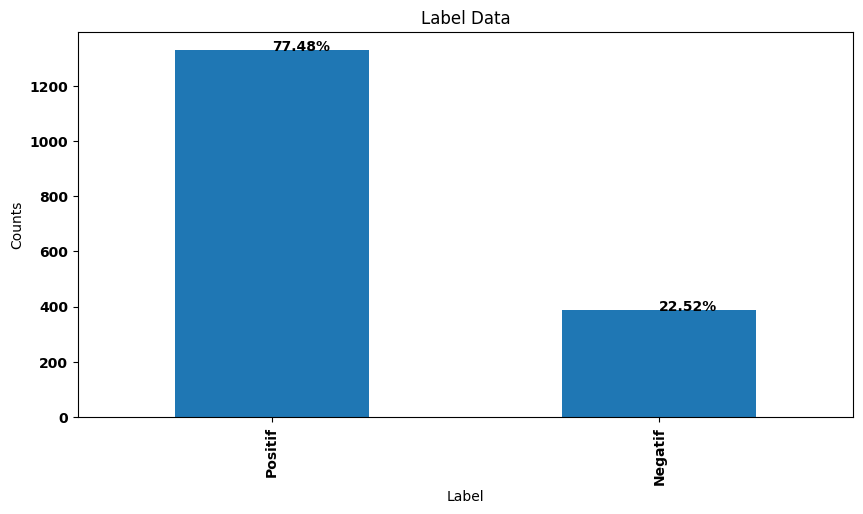

<Figure size 640x480 with 0 Axes>

In [48]:
# Visualisasikan Data Sentiment yang Positif, Netral dan Negatif dengan annotate
plt.figure(figsize=(10, 5))
plt.title('Label Data')
plt.ylabel('Counts')
df_siakad_sentiment['Sentiment'].value_counts().plot(kind='bar')
# Annotate dengan nilainya diubah ke bentuk persen
for index, value in enumerate(df_siakad_sentiment['Sentiment'].value_counts()):
    plt.text(index, value, str(round(value/len(df_siakad_sentiment['Sentiment'])*100,2))+'%')
plt.xlabel('Label')
plt.show()

# simmpan gambar 
plt.savefig('label_siakad.png', bbox_inches='tight')


## Model Machine Learning

In [49]:
# Ubah kolom tweet menjadi bahasa indonesia yg sudah di preprocessing
df_siakad_sentiment['tweet'] = df_siakad['full_text']

# Menghilangkan amatan ganda
df_siakad_sentiment.drop_duplicates(inplace=True)

# Menghilangkan missing value
df_siakad_sentiment.dropna(inplace=True)

#defining X and y for the model
X = df_siakad_sentiment['tweet']
y = df_siakad_sentiment['Sentiment']

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y,test_size=0.3)
Encoder = LabelEncoder()
y_train = Encoder.fit_transform(y_train)
y_test = Encoder.fit_transform(y_test)

Tfidf_vect = TfidfVectorizer(max_features=40000)
Tfidf_vect.fit(X)
Train_X_Tfidf = Tfidf_vect.transform(X_train)
Test_X_Tfidf = Tfidf_vect.transform(X_test)

Train_X_Tfidf_df = pd.DataFrame(Train_X_Tfidf.toarray())
print(Train_X_Tfidf_df)
variance = Train_X_Tfidf_df.var()
print(variance)

print(Train_X_Tfidf)


# vectorizer = CountVectorizer()

# Membandingkan data latih dan data uji dengan rasio 70:30
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
# X_train = vectorizer.fit_transform(X_train)
# X_test = vectorizer.transform(X_test)



      0     1     2     3     4     5     6     7     8     9     ...  4040  \
0      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
1      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
2      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
3      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
4      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
1155   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
1156   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
1157   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
1158   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
1159   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   

      4041  4042  4043  4044  4045  4046  4047  404

### Logistic Regression Model

In [50]:
# Buat model logistic regression
model = LogisticRegression()
model.fit(Train_X_Tfidf, y_train)
y_pred = model.predict(Test_X_Tfidf)


#### Confusion Matrix

In [51]:
y_actual = pd.Series(y_test, name='Actual')
y_predict = pd.Series(y_pred, name='Predicted')
# confusion matrix
confusion_matrix = pd.crosstab(y_actual, y_predict)
confusion_matrix

Predicted,0,1
Actual,,
0,10,110
1,1,377


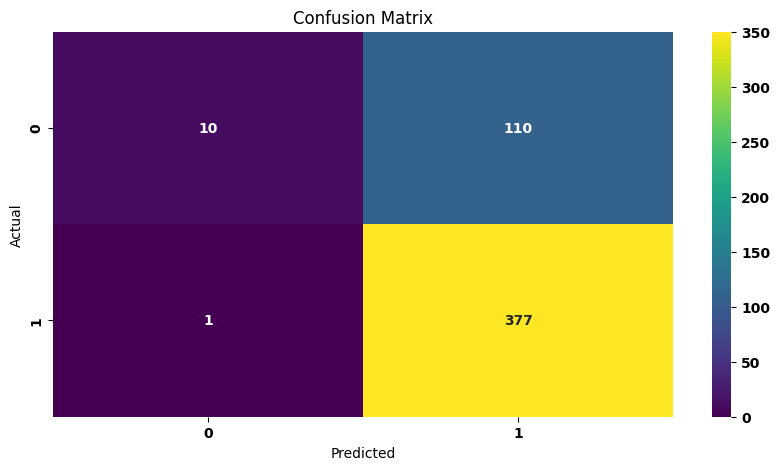

In [54]:
# Visualisasi confusion matrix
plt.figure(figsize=(10, 5))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
sns.heatmap(confusion_matrix, annot=True, fmt='d',cmap="viridis",vmin=0, vmax=350)
plt.show()

# save
plt.savefig('confusion_matrix_siakad.png', bbox_inches='tight')

### Accuracy, Precision and Recall

In [ ]:
# Accuracy model
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy=>')
print('Logistic Regression : ', accuracy)

# Precision, Recall, F1-Score
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))
